<a href="https://colab.research.google.com/github/fernandosjp/puc-rio-data_science/blob/main/model/model_training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criação de modelo para classificação de categoria de transações

## Introdução
Objetivo do modelo: classificar transações em categorias.

Dataset: financial transactions categorized for personal finance purposes

Notebook structure:

1. Load and pre process data
2. Select features and split into train and test datasets
3. Training phase: Create pipelines, vecotrize text data, train model, tune hyper params and evaluate models

- exportação do modelo resultante.

TODOS:
- Levar test dataset para teste na aplicação
- Subir notebook para o github e testar como acessá-lo para rodar treinamento de modelo
- incluir test de modelo BERT ou LLM

# Import

In [1]:
# do not show warnings
import warnings
warnings.filterwarnings("ignore")

# prompt: frame to train and solected machine learning model to classify transactions into categories

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Load and pre process data
Here we will open the csv file and transform categories in labels.

In [3]:
# Dataset URL
url = "https://raw.githubusercontent.com/fernandosjp/puc-rio-data_science/main/model/data/main.csv"
data = pd.read_csv(url, delimiter=',', encoding='utf-8')

data['Description'] = data['Description'].values.astype('U')

# Label categories
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Category'])

# Mostra as primeiras linhas do dataset
data.head()

,Description,Category,Sub_Category,label
0,amFilm Tempered Glass Screen Protector for Nin...,Electronics,Accessories,3
1,"Power Strip with USB, TESSAN Mountable Flat Pl...",Electronics,Accessories,3
2,"USB Wall Charger, Surge Protector, POWRUI 6-Ou...",Electronics,Accessories,3
3,"Anker Power Strip with USB, PowerPort Cube USB...",Electronics,Accessories,3
4,"USB Wall Charger, Surge Protector, 5 Outlet Ex...",Electronics,Accessories,3


# Select features and split train and test datasets

In [5]:
# Define params
test_size = 0.2
random_state = 42

# Select relevant features and target variable
features = ['Description']
target = 'label'

X = data[features]
y = data[target]

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, )

# Training phase
In the training phase we will use train dataset along with cross valiation to train the model and tune hyper parameters. It includes:
- Creating pipelines
- vectorize text data
- train models
- tune hyperparameters
- evaluate models usign cross validation



NB: accuracy 0.946 mean (0.004 std)
NB-std: accuracy 0.898 mean (0.004 std)


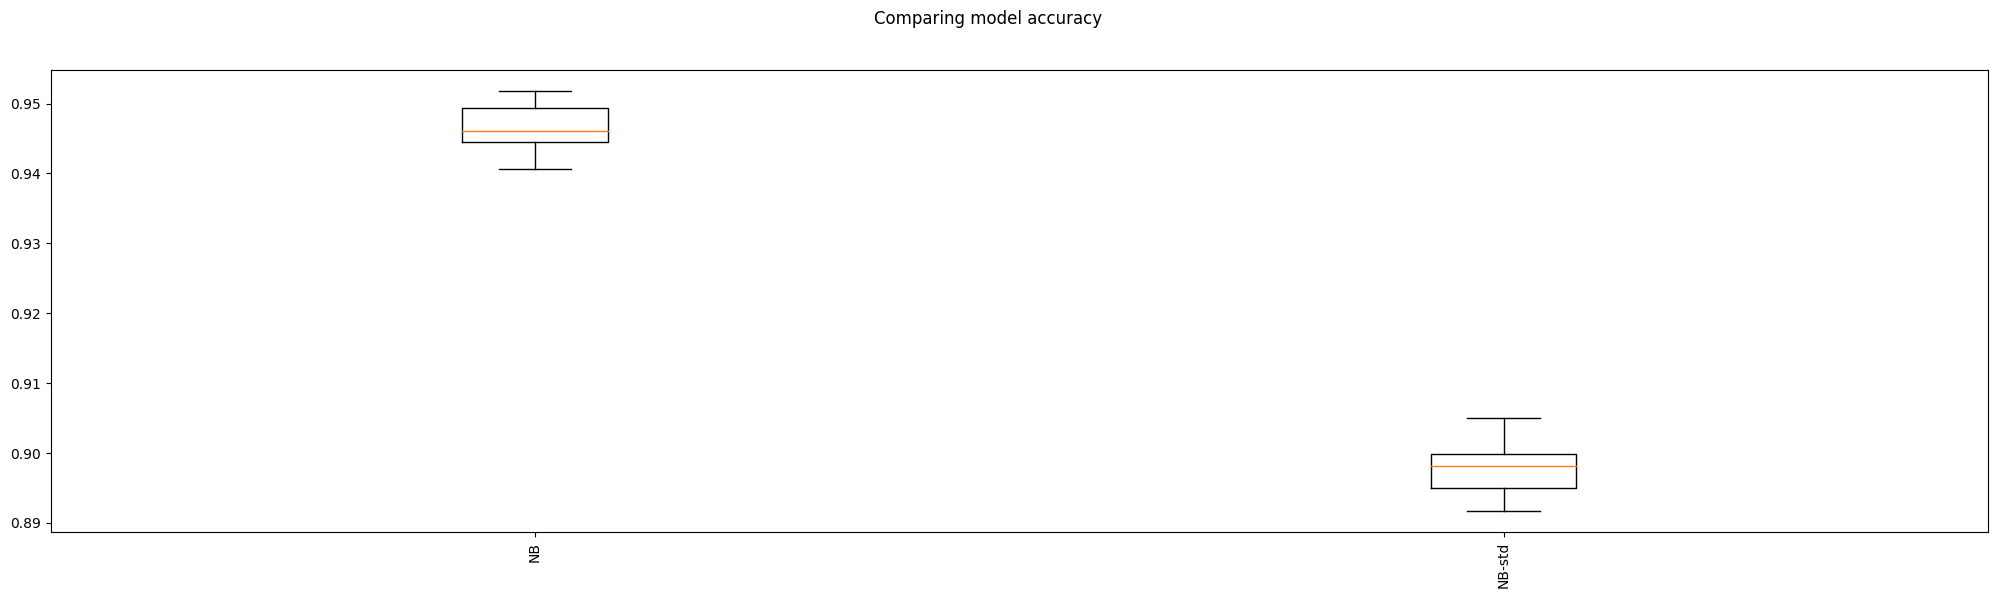

In [8]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state) # validação cruzada com estratificação

results = []
pipelines = []
names = []

# Models
knn = ('KNN', KNeighborsClassifier())
cart =  ('CART', DecisionTreeClassifier())
nb = ('NB', MultinomialNB())
svm = ('SVM', SVC(probability=True))

# Scalers
standard_scaler = ('StandardScaler', StandardScaler(with_mean=False))
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Vectorize text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.Description)
X_test_vec = vectorizer.transform(X_test)

# Create pipelines for different models
# pipelines.append(('KNN', Pipeline([knn])))
# pipelines.append(('CART', Pipeline([cart])))
pipelines.append(('NB', Pipeline([nb])))
# pipelines.append(('SVM', Pipeline([svm])))
# pipelines.append(('KNN-std', Pipeline([standard_scaler, knn])))
# pipelines.append(('CART-std', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-std', Pipeline([standard_scaler, nb])))
# pipelines.append(('SVM-std', Pipeline([standard_scaler, svm])))

# Perform grid search and evaluate models
# Define hyperparameters for grid search
param_grids = {
    'KNN': {'KNN__n_neighbors': [7, 14]},
    'CART': {'CART__max_depth': [None, 5, 10]},
    'NB': {},  # No hyperparameters for Gaussian Naive Bayes
    'SVM': {'SVM__C': [0.1, 1, 10], 'SVM__kernel': ['linear', 'rbf']},
    'KNN-std': {'KNN__n_neighbors': [3, 5, 7]},
    'CART-std': {'CART__max_depth': [None, 5, 10]},
    'NB-std': {},  # No hyperparameters for Gaussian Naive Bayes
    'SVM-std': {'SVM__C': [0.1, 1, 10], 'SVM__kernel': ['linear', 'rbf']},
}
best_models = {}
for name, model in pipelines:
    # Tune hyper parameters
    grid_search = GridSearchCV(model, param_grids[name], scoring=scoring, cv=kfold)
    grid_search.fit(X_train_vec, y_train)
    best_models[name] = grid_search.best_estimator_

    # Run Cross validation and calculate accuracy on training dataset
    cv_results = cross_val_score(best_models[name], X_train_vec, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: accuracy %.3f mean (%.3f std)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparing model accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

# Final Evaluation against test dataset
After evaluating model performance usign kfold on training dataset we will test the models against an unbiased test dataset to have a final opinion if our model was capable of generalize well of it overfitted during training phase

In [9]:
# Calculate Accuracy of test Dataset
# transform the test dataset
X_test_vec = vectorizer.transform(X_test.Description)

# Accuracy on test dataset
for name, model in pipelines:
  # make predictions on the test set
  yhat = best_models[name].predict(X_test_vec)

  # evaluate accuracy
  acc = accuracy_score(y_test, yhat)
  print(f'Model name: {name} and Test Accuracy:{acc:.2f}')

Model name: NB and Test Accuracy:0.94
Model name: NB-std and Test Accuracy:0.90


In [10]:
# Classification report
for name, model in pipelines:
  # make predictions on the test set
  yhat = best_models[name].predict(X_test_vec)
  print(f"Classification Report for {name}:")
  print(classification_report(y_test, yhat))

Classification Report for NB:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       856
           1       0.93      0.82      0.87       387
           2       0.98      0.97      0.97      2607
           3       0.99      0.98      0.98       932
           4       0.87      0.94      0.90      1419
           5       0.97      0.98      0.97      3485
           6       0.91      0.93      0.92      2264
           7       0.00      0.00      0.00         1
           8       0.94      0.71      0.81       233
           9       0.90      0.76      0.82       326
          10       1.00      0.63      0.78        49

    accuracy                           0.94     12559
   macro avg       0.86      0.79      0.82     12559
weighted avg       0.95      0.94      0.94     12559

Classification Report for NB-std:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       856
           1  

# Select model and export model, label encoder and vectorizer

In [12]:
from joblib import dump
from joblib import load

In [13]:
# Selected model
selected_model_name = 'NB'

# save the model
dump(best_models[name], open('model.joblib', 'wb'))
# save the vectorizer
dump(vectorizer, open('vectorizer.joblib', 'wb'))
# save the label encoder
dump(label_encoder, open('label_encoder.joblib', 'wb'))

# Simulate model usage on small sample

In [14]:
# load the model
model_joblib = load(open('model.joblib', 'rb'))
# load the vectorizer
vectorizer_joblib = load(open('vectorizer.joblib', 'rb'))
# load the label encoder
label_encoder_joblib = load(open('label_encoder.joblib', 'rb'))

In [15]:
# Testing model with ramdom descriptions
test_dict = {'Description':  ["Nike", "McDonalds", "Groceries", "Market", "Gas"]}
test_data = pd.DataFrame.from_dict(test_dict)
test_data_vec = vectorizer.transform(test_data.Description)

# Predição de classes dos dados de entrada
y_pred = model_joblib.predict(test_data_vec)
decoded_labels = label_encoder_joblib.inverse_transform(y_pred)
print(decoded_labels)

['Clothes' 'Food' 'Food' 'Home' 'Auto']


# Result Analysis

esumindo os principais achados, analisando os resultados e levantando eventuais pontos de atenção. Sugerimos também incluir um bloco de texto de conclusão do problema como um todo, resumindo os principais pontos e fazendo um fechamento desta parte do trabalho.